In [23]:
from pathlib import Path
import os
import pandas as pd
from collections import defaultdict

from scripts.build_mibig_info_table.create_final_table import nrp_id

nerpa_dir = Path(os.getcwd()).parent.parent

mibig_nrps_table = pd.read_csv(nerpa_dir / 'scripts' / 'build_mibig_info_table' / 'mibig_bgcs_info.tsv', sep='\t')
rban_graphs_table = pd.read_csv(nerpa_dir / 'scripts' / 'build_mibig_info_table' / 'rban_graphs_filtered.tsv', sep='\t')

bgc_to_nrp_iso_classes = defaultdict(set)
for _, row in mibig_nrps_table.iterrows():
    bgc_to_nrp_iso_classes[row['bgc_id']].add(row['iso_class_idx'])


In [24]:
nerpa_report_tsv = Path('/home/ilianolhin/git/nerpa2/benchmarking/cross_validation_results/subset_0/report.tsv')
nerpa_report = pd.read_csv(nerpa_report_tsv, sep='\t')

1. FDR plot --- how many of first N matches are correct?
Match is correct if a BGC is matched with a compound whose graph is isomorphic to one of the BGC's products.

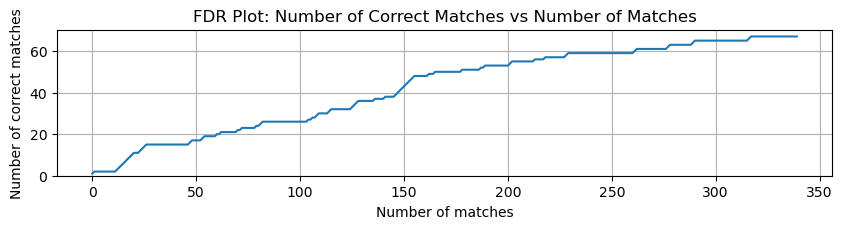

In [25]:
def match_is_correct(report_row):  # row in report.tsv
    nrp_id = report_row['NRP_ID']
    bgc_id = report_row['Genome_ID']
    nrp_class = rban_graphs_table.loc[rban_graphs_table['compound_id'] == nrp_id, 'iso_class_idx'].values[0]
    return nrp_class in bgc_to_nrp_iso_classes[bgc_id]

num_correct = 0
num_correct_array = []
for i, row in nerpa_report.iterrows():
    if match_is_correct(row):
        num_correct += 1
    num_correct_array.append(num_correct)

# q: plot num_correct_array vs i
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(num_correct_array)), num_correct_array)
ax.set_xlabel('Number of matches')
ax.set_ylabel('Number of correct matches')
ax.set_title('FDR Plot: Number of Correct Matches vs Number of Matches')
ax.grid()

ax.set_aspect('equal', adjustable='box')  # Ensures equal aspect ratio with flexible plot box
ax.set_ylim(bottom=0)                     # y-axis starts at 0

plt.show()


2. Score correctness histogram -- how many of the matches with a given score are correct?

/tmp/ipykernel_5647/1009481642.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["score_bin", "is_correct"])


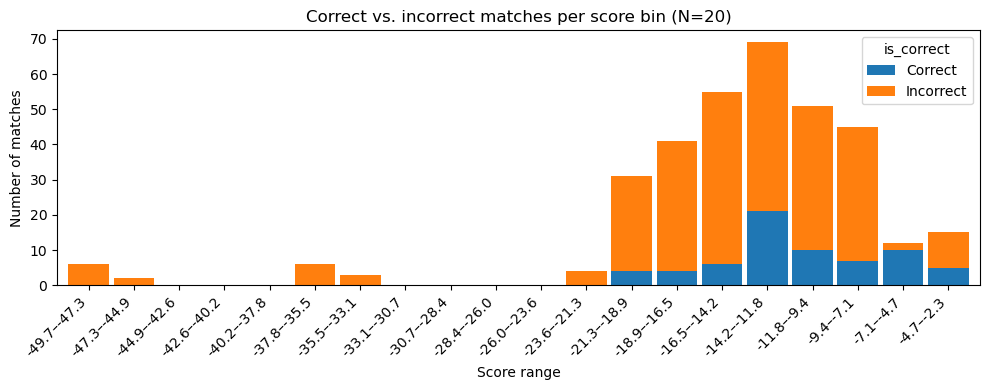

In [28]:
# --- Load results ----------------------------------------------------------
df = nerpa_report.copy()

# --- Determine correctness -------------------------------------------------
# Assumes you already ran the cell that defines `match_is_correct`
df["is_correct"] = df.apply(match_is_correct, axis=1)

# --- Bin scores ------------------------------------------------------------
N_BINS = 20
# Cut scores into equal-width bins; include lowest edge to capture min score
df["score_bin"] = pd.cut(df["Score"], bins=N_BINS, include_lowest=True)
counts = (
    df.groupby(["score_bin", "is_correct"])
      .size()
      .unstack(fill_value=0)               # columns: False / True
      .rename(columns={False: "Incorrect", True: "Correct"})
)

# --- Plot ------------------------------------------------------------------
ax = counts[["Correct", "Incorrect"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10, 4),
    width=0.9,
    rot=45,
    xlabel="Score range",
    ylabel="Number of matches",
    title=f"Correct vs. incorrect matches per score bin (N={N_BINS})"
)
ax.set_xticklabels(
    [f"{iv.left:.1f}–{iv.right:.1f}" for iv in counts.index],
    rotation=45, ha="right"
)
plt.tight_layout()
plt.show()


3. How many BGCs have been identified?

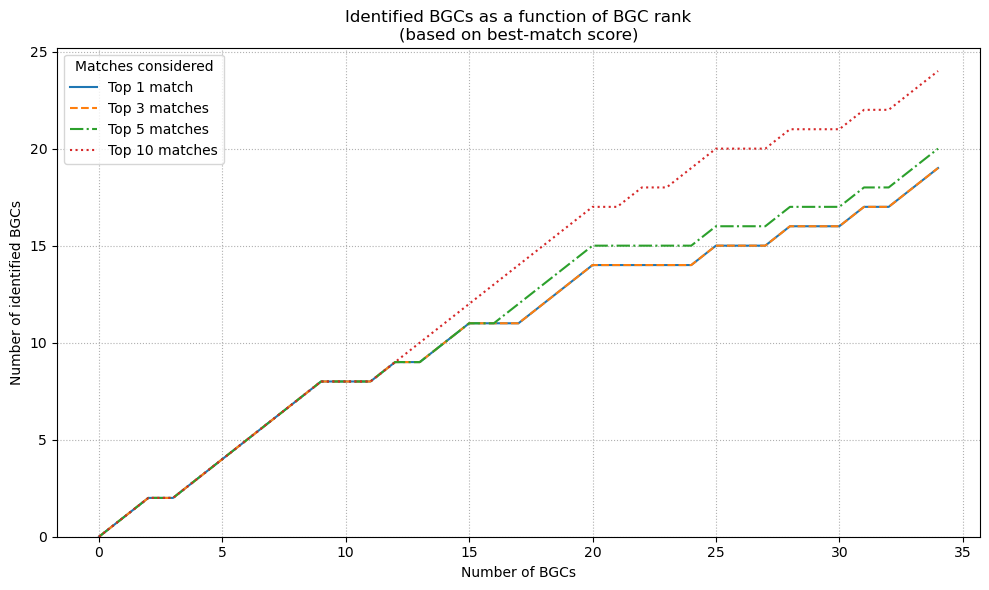

In [33]:
bgc_to_matches = defaultdict(list)
for _, row in nerpa_report.iterrows():
    bgc_id = row['Genome_ID']
    bgc_to_matches[bgc_id].append(row)

for bgc_id, matches in bgc_to_matches.items():
    bgc_to_matches[bgc_id] = sorted(matches, key=lambda x: x['Score'], reverse=True)

# q: sort BGCs by the best match score
bgcs = sorted(bgc_to_matches.keys(),
              key=lambda bgc_id: bgc_to_matches[bgc_id][0]['Score'],
              reverse=True)

# --------------------------------------------------------------------------
# SETTINGS
# --------------------------------------------------------------------------
TOP_K_VALUES = [1, 3, 5, 10]          # how many top matches to test per curve
LINE_STYLE   = ["-", "--", "-.", ":"] # one style per curve (optional)

# --------------------------------------------------------------------------
# BUILD one cumulative-recall curve per k
# --------------------------------------------------------------------------
curves = {}            # k  -> list of cumulative counts
max_len = len(bgcs)    # x-axis length (same for every curve)

for k in TOP_K_VALUES:
    num_identified = 0
    cumulative     = [0]              # start at x = 0, y = 0

    for bgc_id in bgcs:
        if any(match_is_correct(row)              # uses your helper
               for row in bgc_to_matches[bgc_id][:k]):
            num_identified += 1
        cumulative.append(num_identified)

    curves[k] = cumulative

# --------------------------------------------------------------------------
# PLOT
# --------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for idx, k in enumerate(TOP_K_VALUES):
    style = LINE_STYLE[idx % len(LINE_STYLE)]
    ax.plot(range(len(curves[k])), curves[k],
            style, label=f"Top {k} match{'es' if k > 1 else ''}")

ax.set_xlabel("Number of BGCs")
ax.set_ylabel("Number of identified BGCs")
ax.set_title("Identified BGCs as a function of BGC rank\n(based on best-match score)")
ax.grid(True, which="both", linestyle=":")
ax.set_ylim(bottom=0)
ax.legend(title="Matches considered")

# Optional: keep equal aspect if you really want 45° diagonal perception,
# but many people prefer removing it for easier comparison.
# ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

4. How many NRPs were identified?

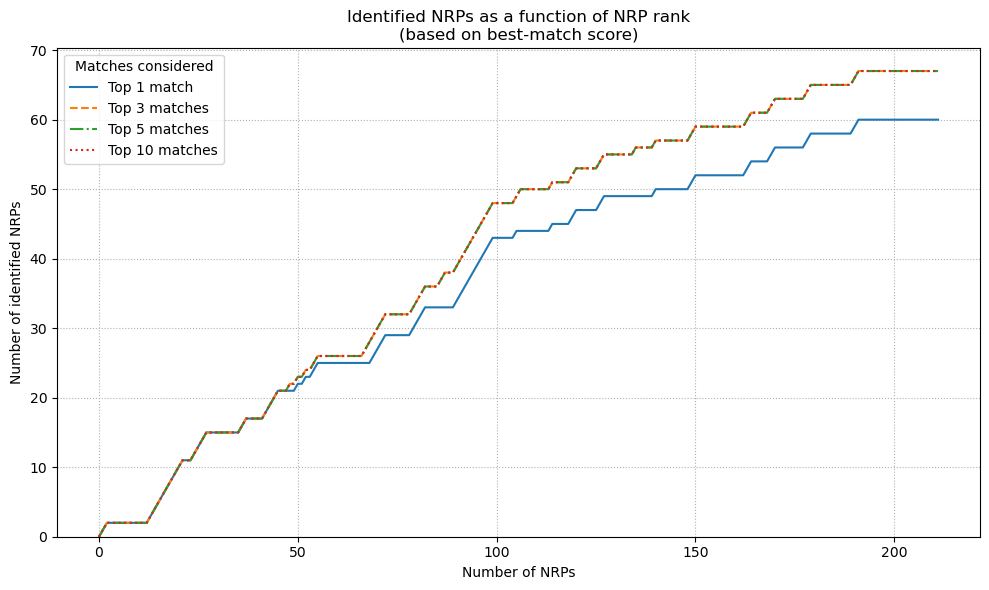

In [34]:
nrp_to_matches = defaultdict(list)
for _, row in nerpa_report.iterrows():
    nrp_id = row['NRP_ID']
    nrp_to_matches[nrp_id].append(row)

for nrp_id, matches in nrp_to_matches.items():
    nrp_to_matches[nrp_id] = sorted(matches, key=lambda x: x['Score'], reverse=True)

# q: sort BGCs by the best match score
nrps = sorted(nrp_to_matches.keys(),
              key=lambda nrp_id: nrp_to_matches[nrp_id][0]['Score'],
              reverse=True)

# --------------------------------------------------------------------------
# SETTINGS
# --------------------------------------------------------------------------
TOP_K_VALUES = [1, 3, 5, 10]          # how many top matches to test per curve
LINE_STYLE   = ["-", "--", "-.", ":"] # one style per curve (optional)

# --------------------------------------------------------------------------
# BUILD one cumulative-recall curve per k
# --------------------------------------------------------------------------
curves = {}            # k  -> list of cumulative counts
max_len = len(bgcs)    # x-axis length (same for every curve)

for k in TOP_K_VALUES:
    num_identified = 0
    cumulative     = [0]              # start at x = 0, y = 0

    for nrp_id in nrps:
        if any(match_is_correct(row)              # uses your helper
               for row in nrp_to_matches[nrp_id][:k]):
            num_identified += 1
        cumulative.append(num_identified)

    curves[k] = cumulative

# --------------------------------------------------------------------------
# PLOT
# --------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for idx, k in enumerate(TOP_K_VALUES):
    style = LINE_STYLE[idx % len(LINE_STYLE)]
    ax.plot(range(len(curves[k])), curves[k],
            style, label=f"Top {k} match{'es' if k > 1 else ''}")

ax.set_xlabel("Number of NRPs")
ax.set_ylabel("Number of identified NRPs")
ax.set_title("Identified NRPs as a function of NRP rank\n(based on best-match score)")
ax.grid(True, which="both", linestyle=":")
ax.set_ylim(bottom=0)
ax.legend(title="Matches considered")

# Optional: keep equal aspect if you really want 45° diagonal perception,
# but many people prefer removing it for easier comparison.
# ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
